In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
from scipy.optimize import minimize
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
import matplotlib.pyplot as plt
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

(CVXPY) Jan 07 08:16:24 PM: Encountered unexpected exception importing solver CVXOPT:
ImportError("dlopen(/opt/anaconda3/lib/python3.12/site-packages/cvxopt/base.cpython-312-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <42996129-43CF-3CE3-AEAF-6CE0B43F76A9> /opt/anaconda3/lib/python3.12/site-packages/cvxopt/base.cpython-312-darwin.so\n  Reason: tried: '/opt/anaconda3/lib/python3.12/site-packages/cvxopt/../../../liblapack.3.dylib' (no such file), '/opt/anaconda3/lib/python3.12/site-packages/cvxopt/../../../liblapack.3.dylib' (no such file), '/opt/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")
(CVXPY) Jan 07 08:16:24 PM: Encountered unexpected exception importing solver GLPK:
ImportError("dlopen(/opt/anaconda3/lib/python3.12/site-packages/cvxopt/base.cpython-312-da

In [2]:
!pip install PyPortfolioOpt --quiet

Tickers & Time Range

In [3]:
tickers = ['ZOMATO.NS','BHARTIARTL.NS','PAYTM.NS','SWIGGY.NS','NYKAA.NS']

In [4]:
end_date = datetime.today()
start_date=end_date-timedelta(days=2*365)

Adjusted Close Prices

In [5]:
df = pd.DataFrame()

In [6]:
for ticker in tickers:
    data=yf.download(ticker,start=start_date,end=end_date)
    df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(df,log_returns=True)
S = risk_models.sample_cov(df,log_returns=True)

In [8]:
print(mu)

ZOMATO.NS        1.013530
BHARTIARTL.NS    0.385021
PAYTM.NS         0.128275
SWIGGY.NS        0.825807
NYKAA.NS         0.000506
dtype: float64


In [9]:
print(S)

               ZOMATO.NS  BHARTIARTL.NS  PAYTM.NS  SWIGGY.NS  NYKAA.NS
ZOMATO.NS       0.148666       0.010502  0.033150   0.111176  0.039835
BHARTIARTL.NS   0.010502       0.041143  0.016808  -0.003616  0.008653
PAYTM.NS        0.033150       0.016808  0.320164   0.023525  0.019359
SWIGGY.NS       0.111176      -0.003616  0.023525   0.358915  0.032961
NYKAA.NS        0.039835       0.008653  0.019359   0.032961  0.122724


In [10]:
# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe(risk_free_rate=.07)
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True,risk_free_rate=.07)

OrderedDict({'ZOMATO.NS': 0.45345, 'BHARTIARTL.NS': 0.5105, 'PAYTM.NS': 0.0, 'SWIGGY.NS': 0.03605, 'NYKAA.NS': 0.0})
Expected annual return: 68.6%
Annual volatility: 22.4%
Sharpe Ratio: 2.75


(0.685908776579707, 0.2238768145429278, 2.7511056821009396)

In [11]:
latest_prices = get_latest_prices(df)
latest_prices

ZOMATO.NS         252.449997
BHARTIARTL.NS    1590.849976
PAYTM.NS          983.200012
SWIGGY.NS         509.250000
NYKAA.NS          172.309998
Name: 2025-01-07 00:00:00, dtype: float64

Greedy Allocation

In [18]:
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=8000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ₹{:.2f}".format(leftover))

Discrete allocation: {'BHARTIARTL.NS': 2, 'ZOMATO.NS': 14, 'SWIGGY.NS': 1}
Funds remaining: ₹774.75


In [19]:
df = pd.DataFrame(data=allocation.values(),index=allocation.keys())
df.columns=['Quantity']

df['Investment'] = df.index.map(latest_prices) * df['Quantity']

df.reset_index(inplace=True)
df.columns = ['Component', 'Quantity', 'Investment']

new_row = {'Component': 'Remaining Funds', 'Quantity': 0, 'Investment': 0}

df.loc[len(df)] = new_row

df.at[df.index[-1], 'Investment'] = leftover

In [20]:
df

,Component,Quantity,Investment
0,BHARTIARTL.NS,2,3181.699951
1,ZOMATO.NS,14,3534.299957
2,SWIGGY.NS,1,509.250000
3,Remaining Funds,0,774.750092


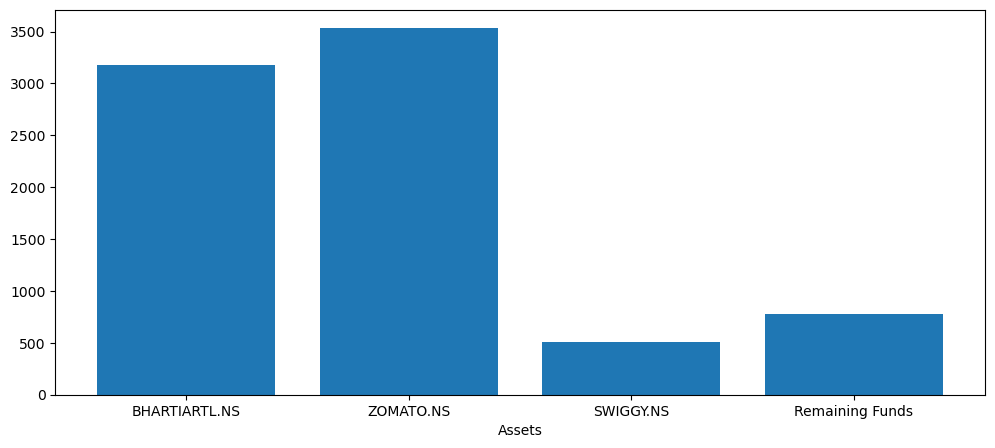

In [21]:
plt.figure(figsize=(12,5))
plt.bar(x=df['Component'],height=df['Investment'])

plt.xlabel('Assets')

plt.show()

Integer Allocation

In [23]:
da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=8000)
allocation, leftover = da.lp_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ₹{:.2f}".format(leftover))

Discrete allocation: {'ZOMATO.NS': 12, 'BHARTIARTL.NS': 3, 'NYKAA.NS': 1}
Funds remaining: ₹25.74


In [24]:
df = pd.DataFrame(data=allocation.values(),index=allocation.keys())
df.columns=['Quantity']

df['Investment'] = df.index.map(latest_prices) * df['Quantity']

df.reset_index(inplace=True)
df.columns = ['Component', 'Quantity', 'Investment']

new_row = {'Component': 'Remaining Funds', 'Quantity': 0, 'Investment': 0}

df.loc[len(df)] = new_row

df.at[df.index[-1], 'Investment'] = leftover

In [25]:
df

,Component,Quantity,Investment
0,ZOMATO.NS,12,3029.399963
1,BHARTIARTL.NS,3,4772.549927
2,NYKAA.NS,1,172.309998
3,Remaining Funds,0,25.740112


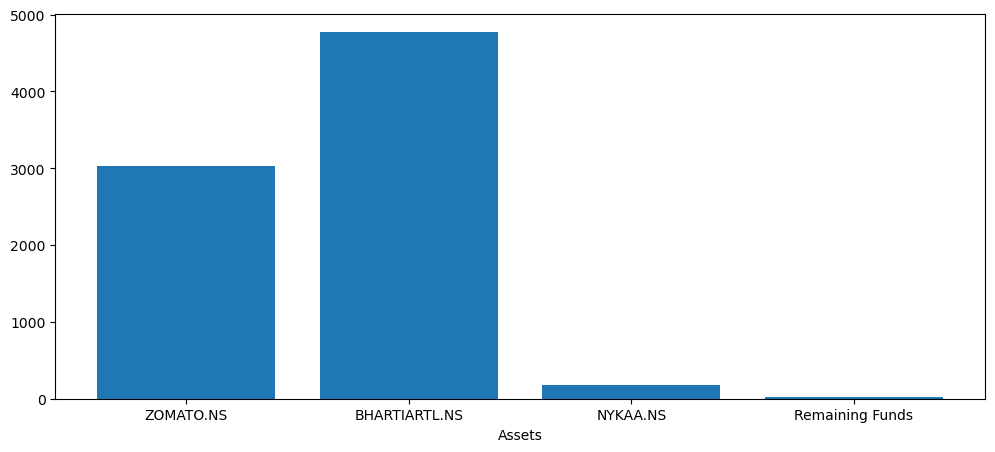

In [26]:
plt.figure(figsize=(12,5))
plt.bar(x=df['Component'],height=df['Investment'])

plt.xlabel('Assets')

plt.show()